### Importing Packages

In [97]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras import backend as K
import warnings
import nltk
nltk.download('stopwords')
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.saving import register_keras_serializable

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [98]:
logger = tf.get_logger()

@register_keras_serializable()
class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [99]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Loading Data

In [100]:
df = pd.read_csv('/kaggle/input/reddit-data/data.csv')
df.head()

,text,summary1,summary2
0,My boyfriend and I are long distance. We have ...,Mum is mad at me for not flying on my own tri...,I have made sure my mother is comfortable wit...
1,My landlord left a falsified message taped to ...,My landlord is harassing me and my neighbours...,landlord pretended to be another tenant and w...
2,"A few months ago, I asked my RA if she wanted ...","RA owes me money, made me buy her toys in a f...",RA verbally abused me and I want to get her t...
3,1) I got a DWI in 2014\n\n2) I have a wonderfu...,"10) On a scale from 1-10, how mad would you b...","I am stuck at work, my girlfriend is going to..."
4,So my wedding dress arrived last week. I had s...,"My dress looks different to how I wanted it, ...",My mother asked my dress maker to change the ...


### Data Pre-Processing

In [101]:
df.drop_duplicates(subset = ['text'], inplace = True)
df.dropna(axis = 0, inplace = True)

df.shape

(20998, 3)

In [102]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have",
                       "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                       "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did",
                       "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have",
                       "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                       "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us",
                       "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                       "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
                       "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
                       "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                       "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                       "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                       "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are",
                       "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have",
                       "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
                       "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have",
                       "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have",
                       "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is",
                       "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have",
                       "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would",
                       "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [7]:
# stop_words = set(nltk.corpus.stopwords.words('english'))

In [103]:
def text_cleaner(text, num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
#     newString = re.sub("[^a-zA-Z]", " ", newString)
#     newString = re.sub('[m]{2,}', 'mm', newString)

    if num == 0:
#         tokens = [w for w in newString.split() if not w in stop_words]
        tokens = newString.split()

    else:
        tokens=newString.split()

#     long_words = []
#     for i in tokens:
#         if len(i) > 1:
#             long_words.append(i)
#     return (" ".join(long_words)).strip()

In [104]:
cleaned_texts = []

for t in df["text"]:
    cleaned_texts.append(text_cleaner(t, 0))

/tmp/ipykernel_47/873031456.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  newString = BeautifulSoup(newString, "lxml").text


In [105]:
cleaned_summaries1 = []

for s in df["summary1"]:
    cleaned_summaries1.append(text_cleaner(s, 1))

/tmp/ipykernel_47/873031456.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  newString = BeautifulSoup(newString, "lxml").text


In [106]:
cleaned_summaries2 = []

for s in df["summary2"]:
    cleaned_summaries2.append(text_cleaner(s, 1))

/tmp/ipykernel_47/873031456.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  newString = BeautifulSoup(newString, "lxml").text


In [107]:
cleaned_df = pd.DataFrame(columns=["text", "summary1", "summary2"])
cleaned_df["text"] = cleaned_texts
cleaned_df["summary1"] = cleaned_summaries1
cleaned_df["summary2"] = cleaned_summaries2

cleaned_df.head()

,text,summary1,summary2
0,my boyfriend and are long distance we have tri...,mum is mad at me for not flying on my own trip...,have made sure my mother is comfortable with m...
1,my landlord left falsified message taped to my...,my landlord is harassing me and my neighbours ...,landlord pretended to be another tenant and wr...
2,few months ago asked my ra if she wanted to pa...,ra owes me money made me buy her toys in fundr...,ra verbally abused me and want to get her to p...
3,got dwi in have wonderful girlfriend who lives...,on scale from how mad would you be with you si...,am stuck at work my girlfriend is going to hoo...
4,so my wedding dress arrived last week had spen...,my dress looks different to how wanted it how ...,my mother asked my dress maker to change the d...


In [108]:
cleaned_df.shape

(20998, 3)

In [109]:
cleaned_df.replace('', np.nan, inplace=True)
cleaned_df.dropna(axis=0,inplace=True)

cleaned_df.shape

(20984, 3)

In [110]:
MAX_TEXT_LEN = 250
MAX_SUMMARY_LEN = 100

In [111]:
cleaned_text = np.array(cleaned_df["text"])
cleaned_summary1 = np.array(cleaned_df["summary1"])
cleaned_summary2 = np.array(cleaned_df["summary2"])

In [112]:
short_text = []
short_summary1 = []
# short_summary2 = []

# for i in range(len(cleaned_text)):
#     if (len(cleaned_summary1[i].split()) <= MAX_SUMMARY_LEN and len(cleaned_text[i].split()) <= MAX_TEXT_LEN):
#         if (len(cleaned_summary2[i].split()) <= MAX_SUMMARY_LEN and len(cleaned_summary2[i].split()) <= MAX_TEXT_LEN):
#             short_text.append(cleaned_text[i])
#             short_summary1.append(cleaned_summary1[i])
#             short_summary2.append(cleaned_summary2[i])

for i in range(len(cleaned_text)):
    if (len(cleaned_summary1[i].split()) <= MAX_SUMMARY_LEN and len(cleaned_text[i].split()) <= MAX_TEXT_LEN):
        short_text.append(cleaned_text[i])
        short_summary1.append(cleaned_summary1[i])
        
# final_dataframe = pd.DataFrame({"text":short_text, "summary1":short_summary1, "summary2":short_summary2})
final_dataframe = pd.DataFrame({"text":short_text, "summary1":short_summary1})

In [113]:
final_dataframe["summary1"] = final_dataframe["summary1"].apply(lambda x: "soseq " + x + " eoseq")
# final_dataframe["summary2"] = final_dataframe["summary2"].apply(lambda x: "soseq " + x + " eoseq")

In [114]:
final_dataframe.shape

(13166, 2)

### Model Training 

In [115]:
texts = np.array(final_dataframe["text"])
summaries = np.array(final_dataframe["summary1"])
# summaries = np.array(final_dataframe["summary2"])

In [116]:
x_train, x_val, y_train, y_val = train_test_split(texts, summaries, test_size = 0.10, random_state = 0, shuffle = True)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size = 0.5, random_state = 0, shuffle = True)

print(len(x_train), len(y_train))
print(len(x_val), len(y_val))
print(len(x_test), len(y_test))

11849 11849
658 658
659 659


In [117]:
print(f'Text:{x_train[0]}')
print()
print(f'Summary:{y_train[0]}')

Text:get back to my apartment after having new people move in it is student style apartment am back to get somethings to move back to my parents house working job that requires me to go back and forth between two cities and cannot find my favorite area rug it is one of those things that found it once and never again so took very good care of it go out to the storage area and find it in bucket of water this causes little ole me to become the hulk finish loading my car in record time lifting things normally need two people to lift and just fuming at the thought this little bag could just do that here where the revenge begins to tickle the back of my brain am currently on the electric bill and was going to leave note that my new shit bag roommates had to pay me each to cover this month well paid this month as was on the phone with my electric company to turn off power to the apartment now it does not really turn it off as the complex pays for electricity when they have no one in the apart

In [118]:
print(f'Text:{x_val[0]}')
print()
print(f'Summary:{y_val[0]}')

Text:am have never been particularly over weight but have always had some what of belly sometime in december at around decided to do insanity here is what looked like then front side after doing insanity and not following any sort of diet ended up here front side at the end of insanity started this day week boot camp at my gym where we do insanity like workouts for an hour tried to go all fruits veggies and meat for awhile but did not really stick to it am definitely maintaining my progress and feel extremely in shape when am exercising feel as though am on the final run towards the finish line and all need to do is build some muscle and burn that last belly when sit down it still rests over my belt yet do not feel fat anywhere else what can do to keep going and uncover those abs need routine that is intense and daily if need be along with some sort of diet plan that is simple and straightforward help me get down the final stretch and get those abs out before june will commit to any ex

In [119]:
print(f'Text:{x_test[0]}')
print()
print(f'Summary:{y_test[0]}')

Text:they have been together for months only and have never met him but recently she has been showing up with bruises all over he has pulled her hair out and left marks on her face but she does not want to do anything he has been in trouble most of his life and am afraid this will only lead to more and also scared for the baby when he arrives live in another city hours away but have friends that are telling me what is going on and no one has done anything as they are afraid of getting involved or having him her hurt even more but believe ignoring it will do nothing to help her and her baby

Summary:soseq am not sure who to contact or what can do even if she is not willing to press charges but she is woman that needs help eoseq


In [120]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

In [21]:
# threshold = 4

# count = 0
# total_count = 0
# freq = 0
# total_freq = 0

# for key, value in x_tokenizer.word_counts.items():
#   total_count += 1
#   if value < threshold:
#     count += 1

In [121]:
# common_words = total_count - count

# x_tokenizer = Tokenizer(num_words=common_words)
# x_tokenizer.fit_on_texts(list(x_train))

x_train_seq = x_tokenizer.texts_to_sequences(x_train)
x_val_seq = x_tokenizer.texts_to_sequences(x_val)
x_test_seq = x_tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(x_train_seq, maxlen=MAX_TEXT_LEN, padding="post")
x_val = pad_sequences(x_val_seq, maxlen=MAX_TEXT_LEN, padding="post")
x_test = pad_sequences(x_test_seq, maxlen=MAX_TEXT_LEN, padding="post")

x_vocab = len(x_tokenizer.word_index) + 1

In [122]:
print(f'Size of vocabulary (X): {x_vocab}')

Size of vocabulary (X): 27315


In [123]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

In [24]:
# threshold = 6

# count = 0
# total_count = 0
# freq = 0
# total_freq = 0

# for key, value in y_tokenizer.word_counts.items():
#   total_count += 1
#   if value < threshold:
#     count += 1

In [124]:
# common_words = total_count - count

# y_tokenizer = Tokenizer(num_words=common_words)
# y_tokenizer.fit_on_texts(list(y_train))

y_train_seq = y_tokenizer.texts_to_sequences(y_train)
y_val_seq = y_tokenizer.texts_to_sequences(y_val)
y_test_seq = y_tokenizer.texts_to_sequences(y_test)

y_train = pad_sequences(y_train_seq, maxlen=MAX_SUMMARY_LEN, padding="post")
y_val = pad_sequences(y_val_seq, maxlen=MAX_SUMMARY_LEN, padding="post")
y_test = pad_sequences(y_test_seq, maxlen=MAX_SUMMARY_LEN, padding="post")

y_vocab = len(y_tokenizer.word_index) + 1

In [125]:
print(f'Size of vocabulary (Y): {y_vocab}')

Size of vocabulary (Y): 10567


In [126]:
index = []

for i in range(len(y_train)):
    count = 0
    for j in y_train[i]:
        if j != 0:
            count += 1
    if count == 2:
        index.append(i)

y_train = np.delete(y_train, index, axis=0)
x_train = np.delete(x_train, index, axis=0)

In [127]:
index = []

for i in range(len(y_val)):
    count = 0
    for j in y_val[i]:
        if j != 0:
            count += 1
    if count == 2:
        index.append(i)

y_val = np.delete(y_val, index, axis=0)
x_val = np.delete(x_val, index, axis=0)

In [128]:
index = []

for i in range(len(y_test)):
    count = 0
    for j in y_test[i]:
        if j != 0:
            count += 1
    if count == 2:
        index.append(i)

y_test = np.delete(y_test, index, axis=0)
x_test = np.delete(x_test, index, axis=0)

In [129]:
x_train_m = [x_train, y_train[:,:-1]]
y_train_m = y_train.reshape(y_train.shape[0],y_train.shape[1], 1)[:,1:]
x_val_m = [x_val, y_val[:,:-1]]
y_val_m = y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]

In [133]:
EPOCHS = 15
BATCH_SIZE = 128
LATENT_DIM = 100
EMBED_DIM = 90

In [134]:
encoder_input = Input(shape=(MAX_TEXT_LEN, ), name="encoder_input")

encoder_embed = Embedding(x_vocab, EMBED_DIM, trainable=True, name="encoder_embeding")(encoder_input)

encoder_lstm1 = LSTM(LATENT_DIM, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4, name="enc_lstm_1")
encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embed)

encoder_lstm2 = LSTM(LATENT_DIM, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4, name="enc_lstm_2")
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(LATENT_DIM, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4, name="enc_lstm_3")
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

decoder_input = Input(shape=(None, ), name="decoder_input")

decoder_embed_layer = Embedding(y_vocab, EMBED_DIM, trainable=True)
decoder_embed = decoder_embed_layer(decoder_input)

decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4, name="decoder_lstm")
decoder_lstm_output, decoder_h1, decoder_c1 = decoder_lstm(decoder_embed, initial_state=[state_h3, state_c3])

attention_layer = AttentionLayer(name="attention_layer")
attention_output, attention_state = attention_layer([encoder_output3, decoder_lstm_output])

decoder_concat = Concatenate(axis=-1, name="decoder_concat")([decoder_lstm_output, attention_output])

decoder_dense = TimeDistributed(Dense(y_vocab, activation="softmax"))
decoder_output = decoder_dense(decoder_concat)

model = Model([encoder_input, decoder_input], decoder_output)

In [135]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 250)]                0         []                            
                                                                                                  
 encoder_embeding (Embeddin  (None, 250, 90)              2458350   ['encoder_input[0][0]']       
 g)                                                                                               
                                                                                                  
 enc_lstm_1 (LSTM)           [(None, 250, 100),           76400     ['encoder_embeding[0][0]']    
                              (None, 100),                                                        
                              (None, 100)]                                                  

In [136]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [137]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.15, patience=2, min_lr=0.0001)

In [ ]:
history = model.fit(x_train_m, y_train_m, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val_m, y_val_m),
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/15
53/93 [================>.............] - ETA: 2:30 - loss: 3.6032 - accuracy: 0.7347

In [37]:
from tensorflow.keras.models import load_model
# model.save('/kaggle/input/reddit-data/reddit_model.keras')
model.save('/kaggle/working/reddit_model.keras')

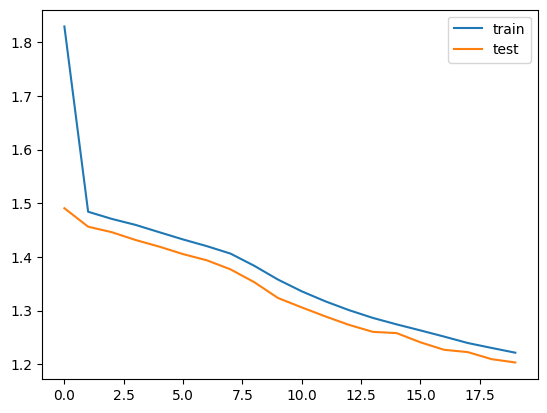

In [38]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [39]:
with open('xtokenizer.pickle', 'wb') as handle:
    pickle.dump(x_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('ytokenizer.pickle', 'wb') as handle:
    pickle.dump(y_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [40]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [41]:
encoder_model = Model(encoder_input, outputs=[encoder_output3, state_h3, state_c3])

decoder_input_state_h = Input(shape=(LATENT_DIM, ))
decoder_input_state_c = Input(shape=(LATENT_DIM, ))
decoder_input_state_hidden = Input(shape=(MAX_TEXT_LEN, LATENT_DIM))

decoder_embedding_pred = decoder_embed_layer(decoder_input)
decoder_output_p, state_h_p, state_c_p = decoder_lstm(decoder_embedding_pred, initial_state=[decoder_input_state_h, decoder_input_state_c])

attention_out_inference, attention_state_inference = attention_layer([decoder_input_state_hidden, decoder_output_p])
decoder_concat = Concatenate(axis=-1, name="concat_attention")([decoder_output_p, attention_out_inference])

decoder_final_output = decoder_dense(decoder_concat)

decoder_model = Model(
    [decoder_input] + [decoder_input_state_hidden, decoder_input_state_h, decoder_input_state_c],
    [decoder_final_output] + [state_h_p, state_c_p])

In [42]:
def sequence_decoder(input_sequence):
    encoder_output, encoder_h, encoder_c = encoder_model.predict(input_sequence, verbose=None)
    target_sequence = np.zeros((1, 1))
    target_sequence[0, 0] = target_word_index["soseq"]

    decoded_sentence = ""
    stop = False

    while not stop:
        output_token, h, c = decoder_model.predict([target_sequence] + [encoder_output, encoder_h, encoder_c], verbose=None)

        predicted_token_index = np.argmax(output_token[0, -1, :])
        predicted_token = reverse_target_word_index[predicted_token_index]

        if  predicted_token != "eoseq":
            decoded_sentence += " " + predicted_token

        if predicted_token == "eoseq" or len(decoded_sentence.split()) >= MAX_SUMMARY_LEN - 1:
            stop = True

        target_sequence = np.zeros((1,1))
        target_sequence[0, 0] = predicted_token_index

        encoder_h, encoder_c = h, c

    return decoded_sentence

In [43]:
def sequence_to_summary(input_seuqnece):
    sentence = ""
    for i in input_seuqnece:
        if i != 0 and i != target_word_index["soseq"] and i != target_word_index["eoseq"]:
            sentence = sentence + reverse_source_word_index[i] + " "

    return sentence

In [44]:
def sequence_to_text(input_seuqnece):
    sentence = ""
    for i in input_seuqnece:
        if i != 0 :
            sentence = sentence + reverse_source_word_index[i] + " "

    return sentence

In [45]:
for i in range(50, 55):
    print("Review:", sequence_to_text(x_test[i]))
    print("Original summary:", sequence_to_summary(y_test[i]))
    print("Predicted summary:", sequence_decoder(x_test[i].reshape(1,MAX_TEXT_LEN)))
    print("\n")

Review: like movie girl dragon tattoo lot however never see scene raped heart pound sick feeling stomach get unsettled feeling ever since saw first time ever watched always change channel scene homework door open tonight heard dad watching living room outside bedroom paying attention watching good blocking noises suddenly noticed heart started pounding getting tense sick feeling get whenever see torture scene television mouth dry stopped typing assignment tried figure wrong hear television next room strange creepy music sound like desperate angry growling could place first suddenly get image getting raped head realize sound actually picture mind frame frame going depending pitch muffled screams heart started beating even faster quickly got silently closed door bizarre anyone ever similar experience 
Original summary: scared content relationship employees really friends awake going seat walked make fast ridiculous zero begin really split ago least head abroad today make love 
Predicted 